# Prepare Data

In [ ]:
from google.colab import files
from google.colab import drive

from keras.models import Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Softmax
from keras.engine.saving import model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import os
import sys

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

import librosa
import librosa.display

import tensorflow as tf

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
iemocap = "gdrive/My Drive/Public/IEMOCAP_full_release"

Mounted at /content/gdrive


# Convert into CSV

In [ ]:
sessions = ["Session1", "Session2", "Session3", "Session4", "Session5"]

def convertSession(session_name):
  session_file = iemocap + "/Duration/Processed/" + session_name + ".txt"
  tokenized_lines = []

  with open(session_file) as f:
    lines = f.readlines()
    tokenizedLines = [x.split() for x in lines]

  session_csv = iemocap + "/Duration/Processed/" + session_name + ".csv"
  with open(session_csv, "w") as csv:
    audio_name = ''

    for line in tokenizedLines:
      if line[0] == "Recording":
        audio_name = line[1]
      else:
        csv.write(audio_name + ";" + line[0] + ";" + line[1] + "\n")

def convertRawToCsv():
  for session in sessions:
    convertSession(session)

# convertRawToCsv()

# Convert into data frame

In [ ]:
def getSessionData(session_name):
  df = pd.read_csv(iemocap + "/Duration/Processed/" + session_name + ".csv", delimiter=";", header=None)
  df.columns = ["Audio Name", "Part", "Duration"]
  print(session_name + " count: " + str(len(df.index)))

  return df

def getDataFrame():
  result = pd.DataFrame()

  for session in sessions:
    df = getSessionData(session)
    result = result.append(df, ignore_index=True)

  return result

result = getDataFrame()
result["Duration"] = result["Duration"].apply(np.floor).astype(int)
result

Session1 count: 1819
Session2 count: 1811
Session3 count: 2136
Session4 count: 2103
Session5 count: 2170


,Audio Name,Part,Duration
0,Ses01F_impro01,F000,1
1,Ses01F_impro01,F001,1
2,Ses01F_impro01,F002,3
3,Ses01F_impro01,F003,1
4,Ses01F_impro01,F004,3
...,...,...,...
10034,Ses05M_script03_2,M041,8
10035,Ses05M_script03_2,M042,1
10036,Ses05M_script03_2,M043,2
10037,Ses05M_script03_2,M044,4


# Plot

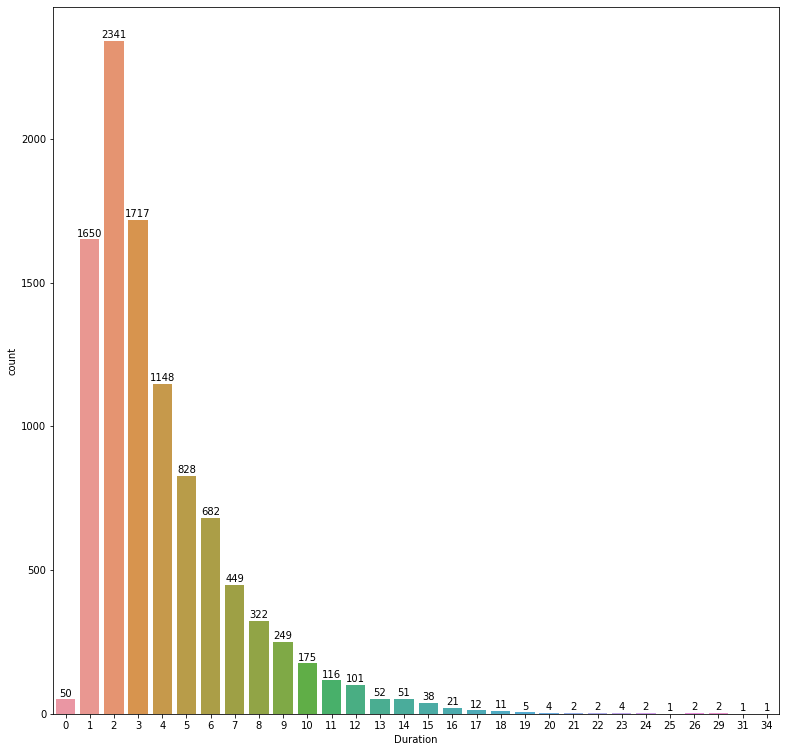

In [ ]:
plot = seaborn.countplot(x='Duration', data=result)
plot.figure.set_size_inches(13,13)

for p in plot.patches:
  height = p.get_height()
  plot.text(p.get_x() + p.get_width()/2., height + 10, '{:1.0f}'.format(height), ha="center") 

In [ ]:
print("Original data: " + str(result.count()))

count_data = result.value_counts(subset=['Duration'], sort=False).values
count_normalize = result.value_counts(subset=['Duration'], sort=False, normalize=True).values
duration = sorted(result.Duration.unique())

count_df = pd.DataFrame({"Duration": duration, "Count": count_data, "Percentage": count_normalize})
count_df.Percentage = (count_df.Percentage * 100).round(3)
count_df

Original data: Audio Name     10039
Part           10039
Duration       10039
Evaluation1        0
Evaluation2        0
Evaluation3        0
Evaluation4        0
Evaluation5        0
Evaluation6        0
Emotion        10039
dtype: int64


,Duration,Count,Percentage
0,0,50,0.498
1,1,1650,16.436
2,2,2341,23.319
3,3,1717,17.103
4,4,1148,11.435
5,5,828,8.248
6,6,682,6.794
7,7,449,4.473
8,8,322,3.207
9,9,249,2.480


# Labeling

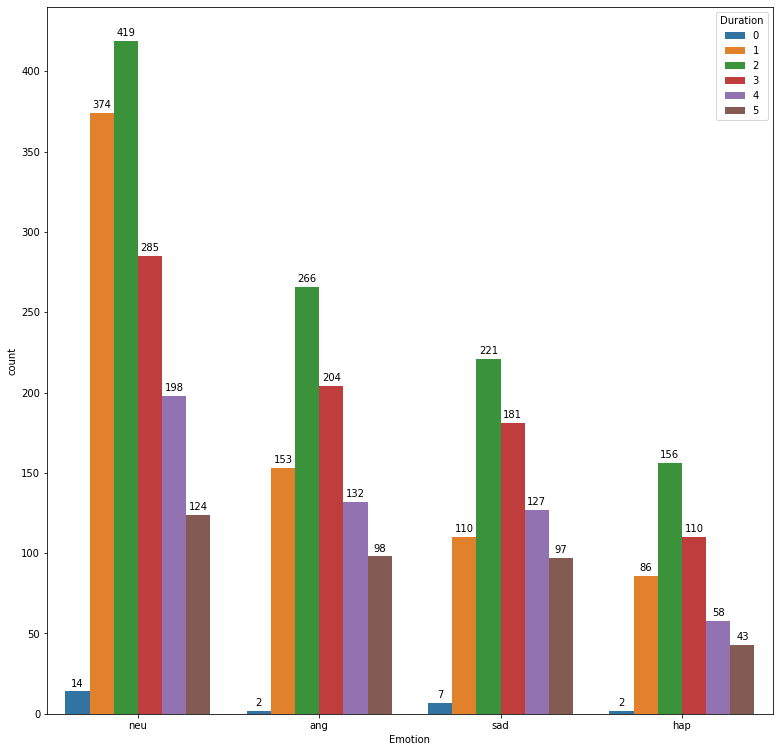

In [ ]:
# emotion_column = ["Evaluation1", "Evaluation2", "Evaluation3", "Evaluation4", "Evaluation5", "Evaluation6"]

def resetEvaluation():
  # for column in emotion_column:
  #   result[column] = None

  result["Emotion"] = None

def goLabeling():
  for session in sessions:
    emotion_path = iemocap + "/" + session + "/dialog/EmoEvaluation/"

    recordings = [file.name for file in os.scandir(emotion_path) if ".txt" in file.name]
    recordings.sort()
    
    for recording in recordings:
      with open(emotion_path + recording) as f:
        lines = f.readlines()
        tokenizedLines = [x.split() for x in lines if "Ses0" in x]

        for part in tokenizedLines:
          line_name = part[3]
          line_label = part[4]
          line_queries = line_name.split("_")
          
          line_part = line_queries[-1]
          line_queries.remove(line_part)

          line_name = "_".join(line_queries)

          search_query_name = ""
          search_query_part = line_queries[-1]
          search_result = result.loc[(result["Audio Name"] == line_name) & (result["Part"] == line_part), "Emotion"]
          search_count = search_result.shape[0]
          
          if search_count == 0:
            print("ERROR: No audio part found: ")
          elif search_count > 1:
            print("ERROR: Multiple audio found: ")
          else:
            result.loc[(result["Audio Name"] == line_name) & (result["Part"] == line_part), "Emotion"] = line_label

def getClassificationReport():
  max_duration = 5

  categorical_data = result.loc[
    (result["Duration"] < max_duration + 1) &
    (
      (result["Emotion"] == 'neu') |
      (result["Emotion"] == 'ang') |
      (result["Emotion"] == 'hap') |
      (result["Emotion"] == 'sad') 
    )
  ]
  
  categorical_plot = seaborn.countplot(x="Emotion", hue="Duration", data=categorical_data)
  categorical_plot.figure.set_size_inches(13,13)

  for p in categorical_plot.patches:
    height = p.get_height()
    categorical_plot.text(p.get_x() + p.get_width()/2., height + 3, '{:1.0f}'.format(height), ha="center") 

  return categorical_data

resetEvaluation()
goLabeling()
categorical_data = getClassificationReport()

# Selection and Splitting

In [ ]:
def checkAndCreateDirectory(filename):
  if not os.path.exists(os.path.dirname(filename)):
    try:
        os.makedirs(os.path.dirname(filename))
    except OSError as exc: # Guard against race condition
        print(exc.errno)
        if exc.errno != errno.EEXIST:
            raise

def getMfccValue(audio_path):
  audio_file, sample_rate = librosa.load(audio_path)
  S = librosa.feature.mfcc(y=audio_file, sr=48000)

  # TODO: Parameter MFCC, number of coefficient, Normalization
  # asd

  return S

def transformAudio(duration):
  X = [] # Data
  Y = [] # Label

  durationed_data = result.loc[
    (result["Duration"] == duration) &
    (
      (result["Emotion"] == 'neu') |
      (result["Emotion"] == 'ang') |
      (result["Emotion"] == 'hap') |
      (result["Emotion"] == 'sad') 
    )
  ]
  
  durationed_length = len(durationed_data)
  for index, row in durationed_data.iterrows():
    print("Saving " + str(durationed_length) + " " + str(index), end=" | ")

    if durationed_length % 5 == 0: print("\n")
    durationed_length -= 1

    audio_prefix = row["Audio Name"][:5]
    audio_session = "Error"

    if    (audio_prefix == 'Ses01'): audio_session = "Session1"
    elif  (audio_prefix == 'Ses02'): audio_session = "Session2"
    elif  (audio_prefix == 'Ses03'): audio_session = "Session3"
    elif  (audio_prefix == 'Ses04'): audio_session = "Session4"
    elif  (audio_prefix == 'Ses05'): audio_session = "Session5"

    audio_path = iemocap + '/' + audio_session + '/sentences/wav/' + row["Audio Name"] + '/' + row["Audio Name"] + '_' + row["Part"] + '.wav'

    mfcc = getMfccValue(audio_path)
    mfcc_length = mfcc.shape[1]

    if mfcc_length > (50 * duration):
      mfcc = mfcc[:,:(50 * duration)]
    else:
      mfcc = np.pad(mfcc, pad_width=((0, 0), (0, ((50 * duration) - mfcc_length))), mode='constant')

    label = row["Emotion"]
    label_hot = [0, 0, 0, 0]
    
    if    (label == "neu"): label_hot = [1, 0, 0, 0]
    elif  (label == "ang"): label_hot = [0, 1, 0, 0]
    elif  (label == "hap"): label_hot = [0, 0, 1, 0]
    elif  (label == "sad"): label_hot = [0, 0, 0, 1]
 
    if label_hot == [0, 0, 0, 0]:
      print("ERROR Label " + index + row)
      break

    if (mfcc.shape[1] != (50 * duration)) | (mfcc.shape[0] != 20):
      print("ERROR Mfcc " + index + row)
      break

    X.append(mfcc)
    Y.append(label_hot)

  return np.array(X), np.array(Y)

def clearLocalFolder():
  !rm -rf transformed_image

def downloadLocalData():
  !zip -r /content/transformed_image.zip /content/transformed_image
  files.download("/content/transformed_image.zip")

# clearLocalFolder()
# downloadLocalData()

X, Y = transformAudio(1)

Saving 723 0 | Saving 722 1 | Saving 721 66 | Saving 720 77 | 

Saving 719 87 | Saving 718 103 | Saving 717 111 | Saving 716 129 | Saving 715 134 | 

Saving 714 155 | Saving 713 157 | Saving 712 161 | Saving 711 162 | Saving 710 164 | 

Saving 709 173 | Saving 708 174 | Saving 707 182 | Saving 706 202 | Saving 705 214 | 

Saving 704 215 | Saving 703 217 | Saving 702 222 | Saving 701 223 | Saving 700 224 | 

Saving 699 225 | Saving 698 226 | Saving 697 228 | Saving 696 230 | Saving 695 235 | 

Saving 694 236 | Saving 693 241 | Saving 692 242 | Saving 691 247 | Saving 690 249 | 

Saving 689 260 | Saving 688 261 | Saving 687 262 | Saving 686 271 | Saving 685 272 | 

Saving 684 277 | Saving 683 289 | Saving 682 291 | Saving 681 292 | Saving 680 293 | 

Saving 679 294 | Saving 678 296 | Saving 677 297 | Saving 676 301 | Saving 675 302 | 

Saving 674 390 | Saving 673 401 | Saving 672 435 | Saving 671 474 | Saving 670 477 | 

Saving 669 495 | Saving 668 516 | Saving 667 546 | Saving 666 547 |

Streaming output truncated to the last 5000 lines.
578/578 [==============================] - 2s 3ms/step - loss: 17.7930 - accuracy: 0.6431 - val_loss: 30.1451 - val_accuracy: 0.4966

Epoch 03751: val_accuracy did not improve from 0.59310
Epoch 3752/5000
578/578 [==============================] - 2s 3ms/step - loss: 27.6762 - accuracy: 0.5753 - val_loss: 63.2575 - val_accuracy: 0.4828

Epoch 03752: val_accuracy did not improve from 0.59310
Epoch 3753/5000
578/578 [==============================] - 2s 3ms/step - loss: 279.0269 - accuracy: 0.4470 - val_loss: 42717.6172 - val_accuracy: 0.5448

Epoch 03753: val_accuracy did not improve from 0.59310
Epoch 3754/5000
578/578 [==============================] - 2s 3ms/step - loss: 5478.3420 - accuracy: 0.3049 - val_loss: 42.1998 - val_accuracy: 0.4414

Epoch 03754: val_accuracy did not improve from 0.59310
Epoch 3755/5000
578/578 [==============================] - 2s 3ms/step - loss: 47.3739 - accuracy: 0.4355 - val_loss: 41.3689 - val_accurac

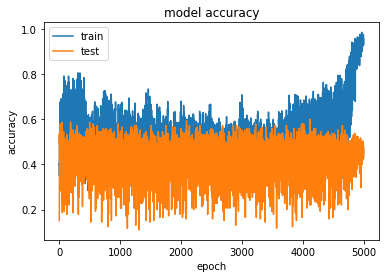

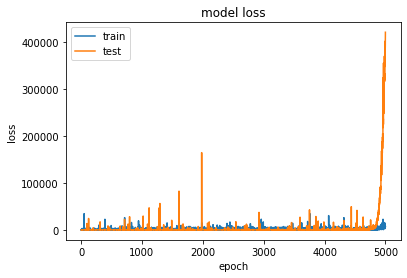

In [19]:
def plot_result(model, history):
  # list all data in history
  print(history.history.keys())

  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def save_model(model, filename):
  checkAndCreateDirectory("model/test.txt")
  model.summary()

  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  with open("model/" + filename + ".json", "w") as json_file:
    model_json = model.to_json()
    json_file.write(model_json)

def buildModel():
  model_input = Input(shape=(20, 50, 1))

  model = Conv2D(256, kernel_size=3, strides=2)(model_input)
  model = Conv2D(256, kernel_size=3, strides=2)(model)
  model = Conv2D(256, kernel_size=3, strides=2)(model)
  
  model = Flatten()(model)

  model = Dense(256)(model)
  model = Dense(256)(model)
  model = Dense(256)(model)

  model = Dense(4, activation='softmax')(model)

  # Data
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state=True, shuffle=True)
  
  # Model compile
  model = Model(inputs=[model_input], outputs=[model])
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  
  # Visualize & Save Model
  save_model(model, "struct_model")

  # Checkpoint
  basepath = '/content/model/weight_model'
  best_checkpoint = ModelCheckpoint(basepath +'_{epoch:02d}_{loss:.2f}_{accuracy:.2f}_{val_loss:.2f}_{val_accuracy:.2f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
  callback_list = [best_checkpoint]

  history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test),
    batch_size=1, 
    epochs=5000,
    callbacks=callback_list
  )

  return model, history

!rm -rf /content/model
model, history = buildModel()
plot_result(model, history)